In [2]:
import warnings
warnings.filterwarnings('ignore')

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df = df.rename(columns={'Agency Type':'Type',
                        'Distribution Channel':'Distribution',
                        'Product Name':'Product',
                        'Net Sales':'Sales',
                        'Commision (in value)':'Commision'})

## ***Function***

In [5]:
#Function for category graphic

def plot_count_plots(df, columns, figsize=(20, 15)):
    plt.figure(figsize=figsize)
    
    for i, col in enumerate(columns):
        plt.subplot(2, 3, i + 1)
        sns.countplot(x=col, data=df, palette='Set1', order=df[col].value_counts().index)
        plt.title(f'Count of {col}')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.suptitle('Count Plots of Categorical Columns', fontsize=16, y=1.02)
    plt.show()



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_scatter(df, x_col, y_col, figsize=(20, 8)):
    plt.figure(figsize=figsize)
    
    sns.scatterplot(x=x_col, y=y_col, data=df)
    plt.title(f'{x_col} vs {y_col}', fontsize=16)
    plt.xlabel(x_col, fontsize=16)
    plt.ylabel(y_col, fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    
    plt.tight_layout()
    plt.show()


# plot_scatter(df_analysis, 'Sales', 'Profit')


## **1. *Descriptive Statistics***

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Agency        44328 non-null  object 
 1   Type          44328 non-null  object 
 2   Distribution  44328 non-null  object 
 3   Product       44328 non-null  object 
 4   Gender        12681 non-null  object 
 5   Duration      44328 non-null  int64  
 6   Destination   44328 non-null  object 
 7   Sales         44328 non-null  float64
 8   Commision     44328 non-null  float64
 9   Age           44328 non-null  int64  
 10  Claim         44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [8]:
df.isna().sum()

Agency              0
Type                0
Distribution        0
Product             0
Gender          31647
Duration            0
Destination         0
Sales               0
Commision           0
Age                 0
Claim               0
dtype: int64

In [9]:
df = df.dropna(subset=['Gender'])

In [10]:
df.duplicated().any()

True

In [11]:
df = df.drop_duplicates()

In [12]:
# Segment column based on datatype for cool analysis

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("num:", num_cols)
print("cat:", cat_cols)


num: ['Duration', 'Sales', 'Commision', 'Age']
cat: ['Agency', 'Type', 'Distribution', 'Product', 'Gender', 'Destination', 'Claim']


In [13]:
# feature numerical
df[num_cols].describe()

,Duration,Sales,Commision,Age
count,11994.000000,11994.000000,11994.000000,11994.000000
mean,69.158413,57.672973,18.517610,43.753960
std,112.148411,74.065644,25.046143,19.081596
min,0.000000,-357.500000,0.000000,0.000000
25%,10.000000,22.000000,6.750000,31.000000
50%,22.000000,30.000000,9.750000,40.000000
75%,59.000000,56.000000,16.800000,51.750000
max,740.000000,810.000000,283.500000,118.000000


In [14]:
# feature categorical
df[cat_cols].describe()

,Agency,Type,Distribution,Product,Gender,Destination,Claim
count,11994,11994,11994,11994,11994,11994,11994
unique,14,2,2,22,2,73,2
top,C2B,Airlines,Online,Basic Plan,M,SINGAPORE,No
freq,5493,10608,11328,3653,6074,5565,11521


## **2. *Data Cleansing***

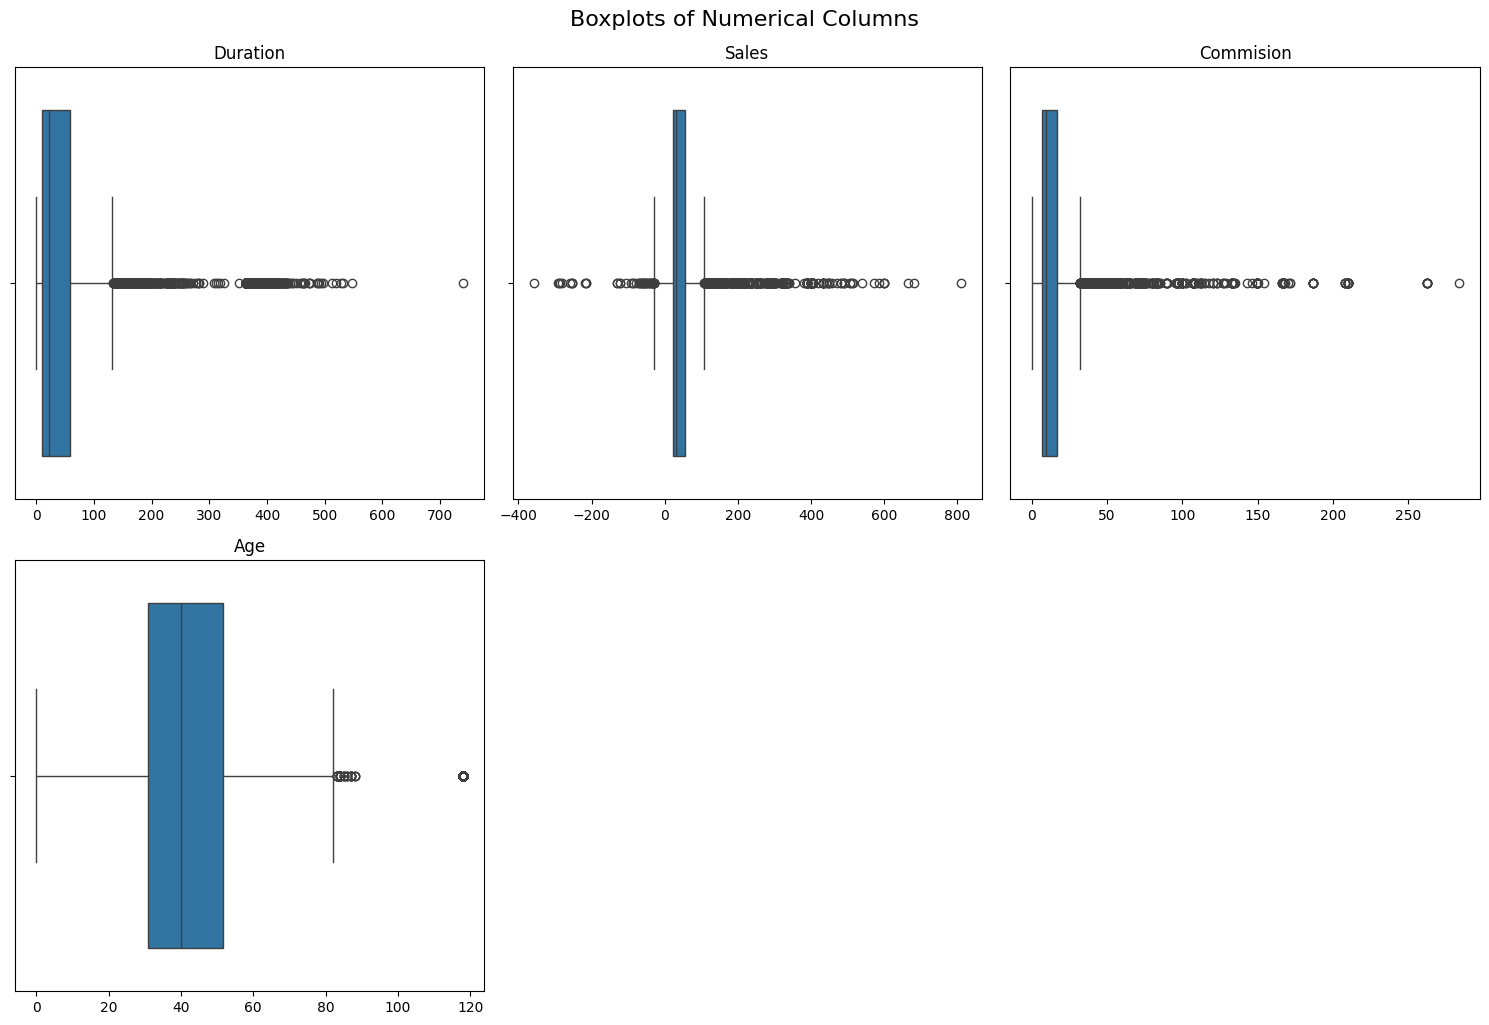

In [15]:
# Visual baby
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot((len(num_cols) // 3) + 1, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'{col}')
    plt.xlabel('')
    plt.tight_layout()

plt.suptitle('Boxplots of Numerical Columns', fontsize=16, y=1.02)
plt.show()

In [16]:
# Outlier based on IQR
outliers_count = {}
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_indices = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers_count[col] = sum(outlier_indices)
    

# Total Outlier
for col in num_cols:
    count = len(df[col])
    print(f"Column '{col}':")
    print(f"  Total values: {count}")
    if col in outliers_count:
        outlier_count = outliers_count[col]
        print(f"  Outliers: {outlier_count}")


Column 'Duration':
  Total values: 11994
  Outliers: 1631
Column 'Sales':
  Total values: 11994
  Outliers: 1609
Column 'Commision':
  Total values: 11994
  Outliers: 1719
Column 'Age':
  Total values: 11994
  Outliers: 421


In [17]:
df_cleaned = df.copy()

for col in num_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

df_cleaned.reset_index(drop=True, inplace=True)

# Total Outlier
for col in num_cols:
    count = len(df_cleaned[col])
    print(f"Column '{col}':")
    print(f"  Total values: {count}")

Column 'Duration':
  Total values: 8764
Column 'Sales':
  Total values: 8764
Column 'Commision':
  Total values: 8764
Column 'Age':
  Total values: 8764


## **3. *Univariate Analysis***

In [18]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8764 entries, 0 to 8763
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Agency        8764 non-null   object 
 1   Type          8764 non-null   object 
 2   Distribution  8764 non-null   object 
 3   Product       8764 non-null   object 
 4   Gender        8764 non-null   object 
 5   Duration      8764 non-null   int64  
 6   Destination   8764 non-null   object 
 7   Sales         8764 non-null   float64
 8   Commision     8764 non-null   float64
 9   Age           8764 non-null   int64  
 10  Claim         8764 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 753.3+ KB


In [19]:
columns_to_drop = ['Gender']

# new df for convinience
df_analysis = df_cleaned.drop(columns=columns_to_drop)

# cheeckkkkkkkkk iitt
print(df_analysis.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8764 entries, 0 to 8763
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Agency        8764 non-null   object 
 1   Type          8764 non-null   object 
 2   Distribution  8764 non-null   object 
 3   Product       8764 non-null   object 
 4   Duration      8764 non-null   int64  
 5   Destination   8764 non-null   object 
 6   Sales         8764 non-null   float64
 7   Commision     8764 non-null   float64
 8   Age           8764 non-null   int64  
 9   Claim         8764 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 684.8+ KB
None


In [20]:
# Segment column based on datatype

num_cols = df_analysis.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df_analysis.select_dtypes(include=['object']).columns.tolist()

print("num:", num_cols)
print("cat:", cat_cols)


num: ['Duration', 'Sales', 'Commision', 'Age']
cat: ['Agency', 'Type', 'Distribution', 'Product', 'Destination', 'Claim']


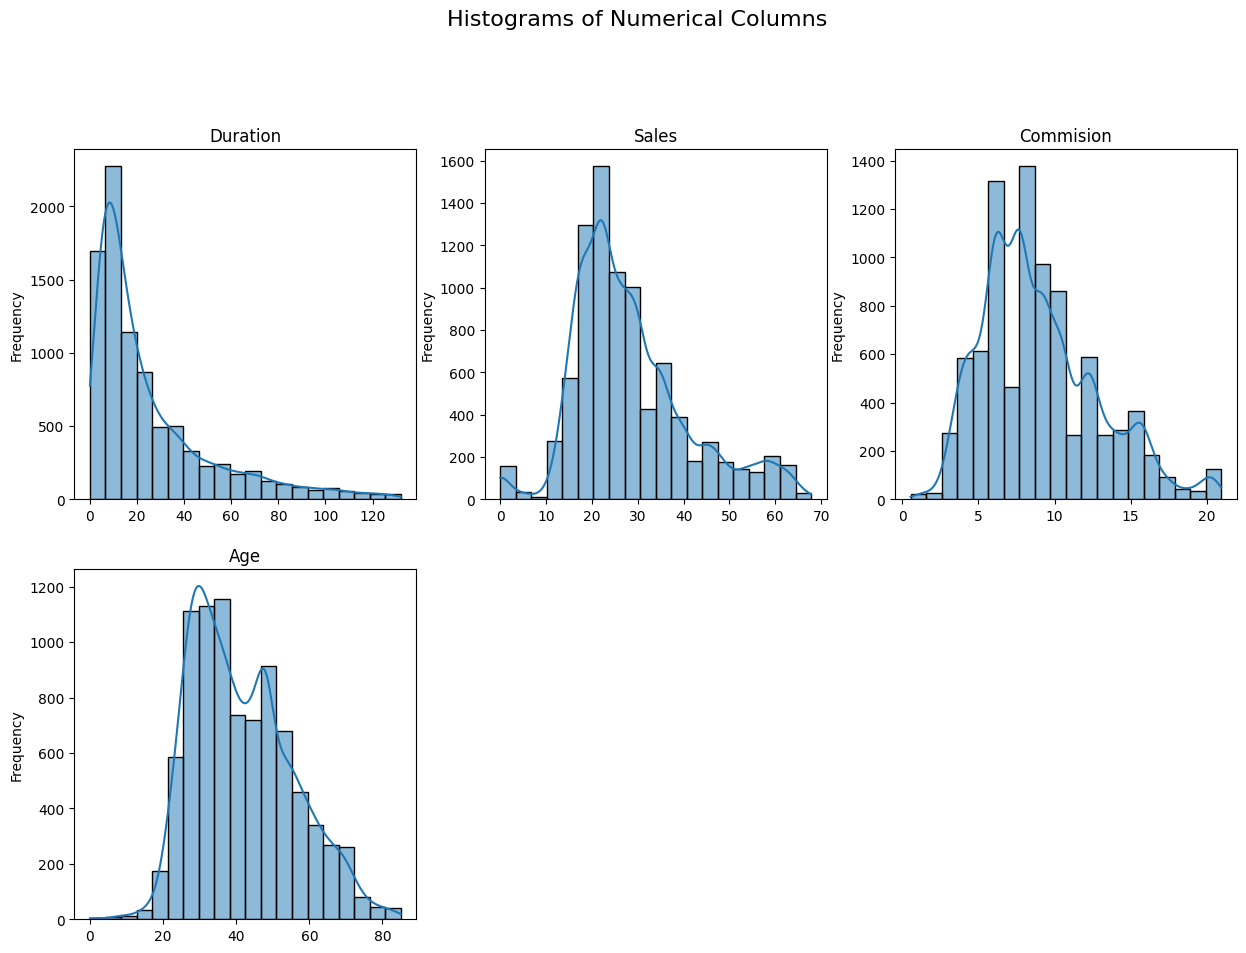

In [21]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(num_cols, 1):
    plt.subplot((len(num_cols) + 2) // 3, 3, i)
    sns.histplot(df_analysis[col], bins=20, kde=True)
    plt.title(f'{col}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Frequency')


plt.suptitle('Histograms of Numerical Columns', fontsize=16, y=1.02)
plt.show()

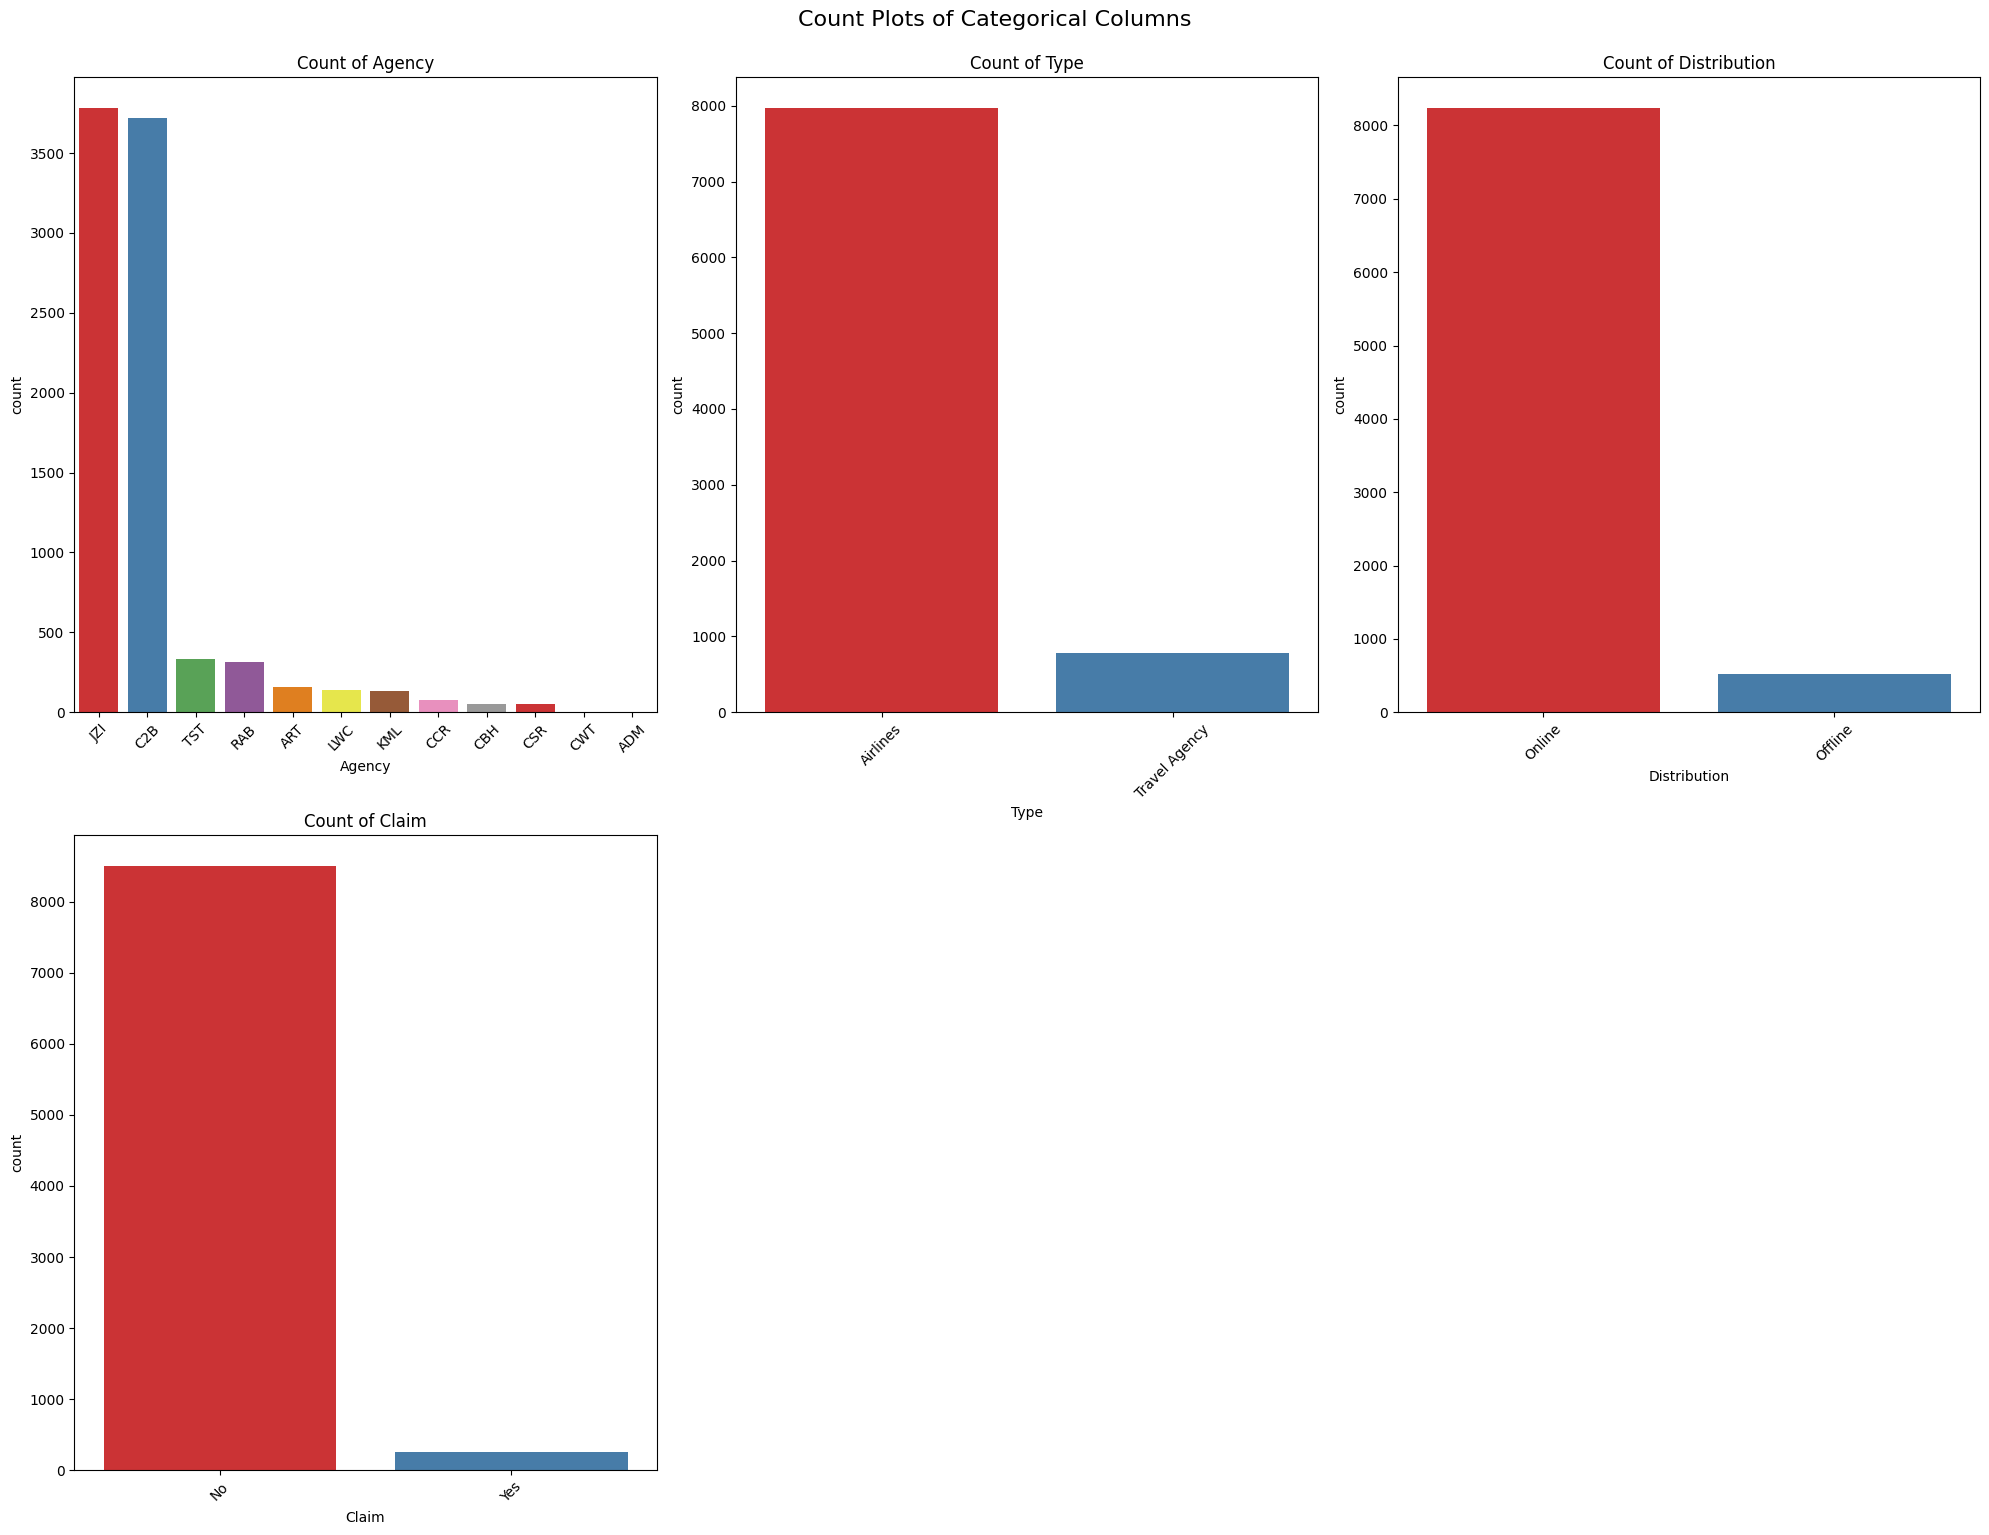

In [22]:
viscat1 = ['Agency', 'Type', 'Distribution', 'Claim']
plot_count_plots(df_analysis, viscat1)

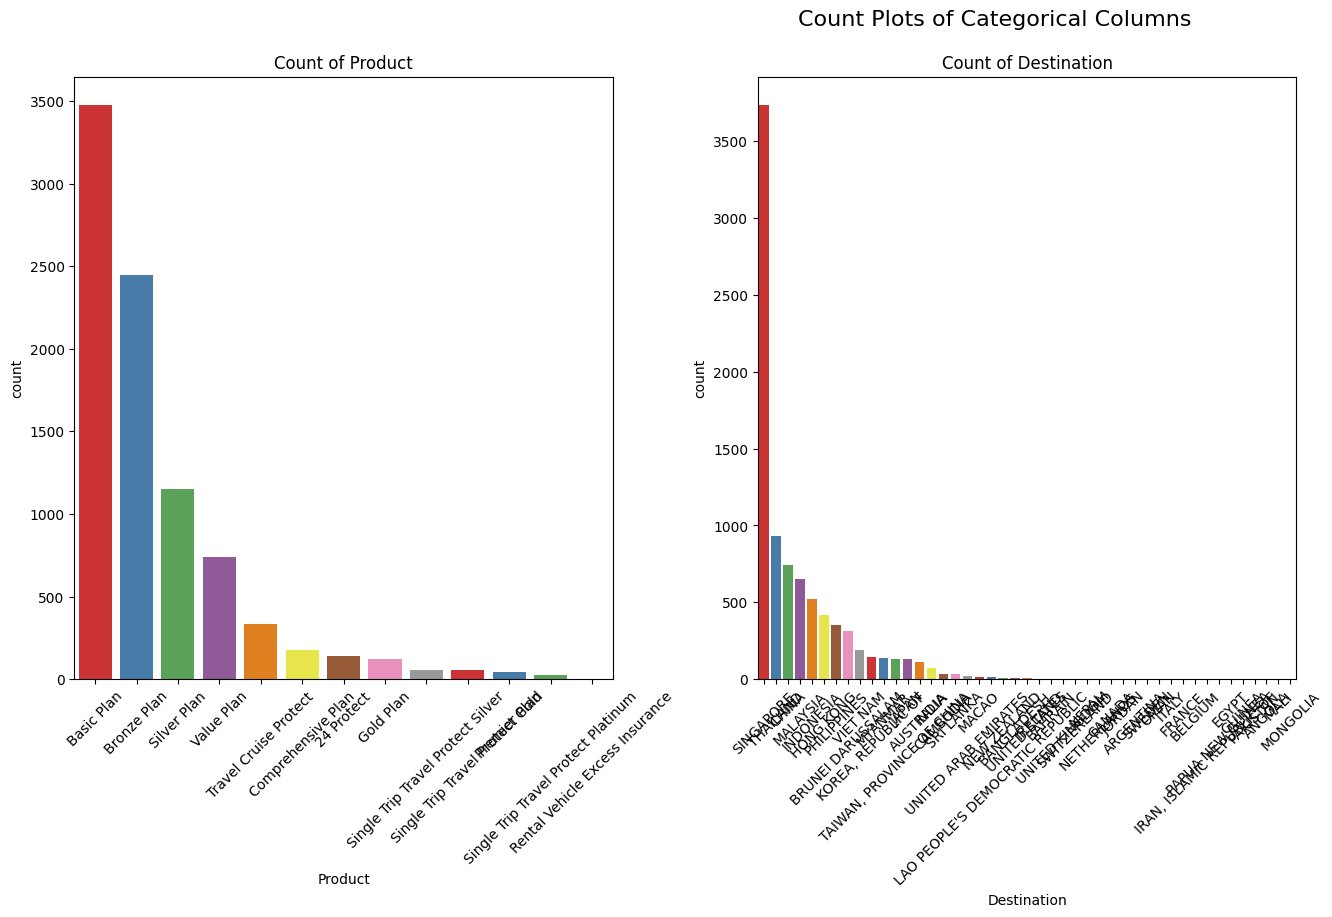

In [23]:
viscat1 = ['Product', 'Destination']
plot_count_plots(df_analysis, viscat1)

In [24]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8764 entries, 0 to 8763
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Agency        8764 non-null   object 
 1   Type          8764 non-null   object 
 2   Distribution  8764 non-null   object 
 3   Product       8764 non-null   object 
 4   Duration      8764 non-null   int64  
 5   Destination   8764 non-null   object 
 6   Sales         8764 non-null   float64
 7   Commision     8764 non-null   float64
 8   Age           8764 non-null   int64  
 9   Claim         8764 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 684.8+ KB


- Insight
1. Focus on the top-performing agencies and strengthen online distribution channels, as they contribute to the majority of sales.

2. The low claim ratio indicates customer satisfaction, suggesting an opportunity to emphasize the preventive nature of travel insurance in marketing efforts.

3. Optimize product offerings based on the most popular products and prioritize online distribution channels for increased sales.

4. Consider targeting both younger and older demographics, particularly for shorter trips, which are more commonly purchased.

5. Recognize and incentivize high-performing agencies to maintain sales momentum, while exploring further opportunities to improve commission structures.

In [25]:
df_analysis.describe()
df_analysis['Claim'].value_counts() 

Claim
No     8510
Yes     254
Name: count, dtype: int64

## **4. *Multivariate Analysis***

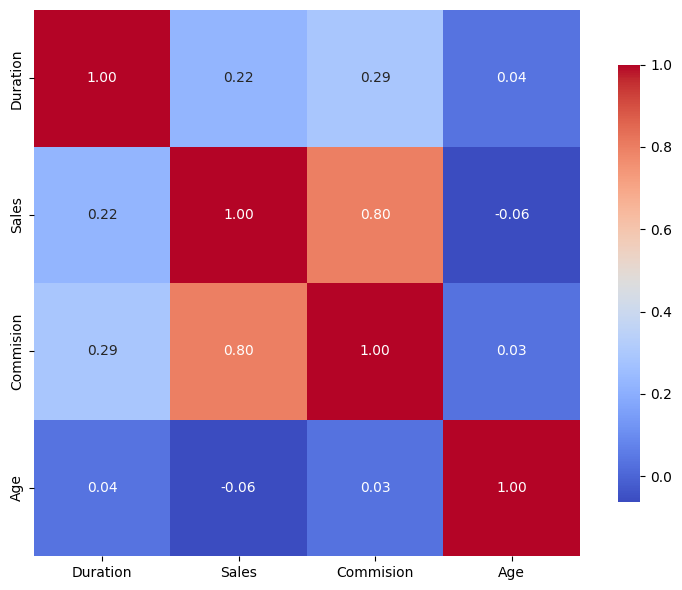

In [26]:
numeric_df = df_analysis.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.tight_layout()
plt.show()


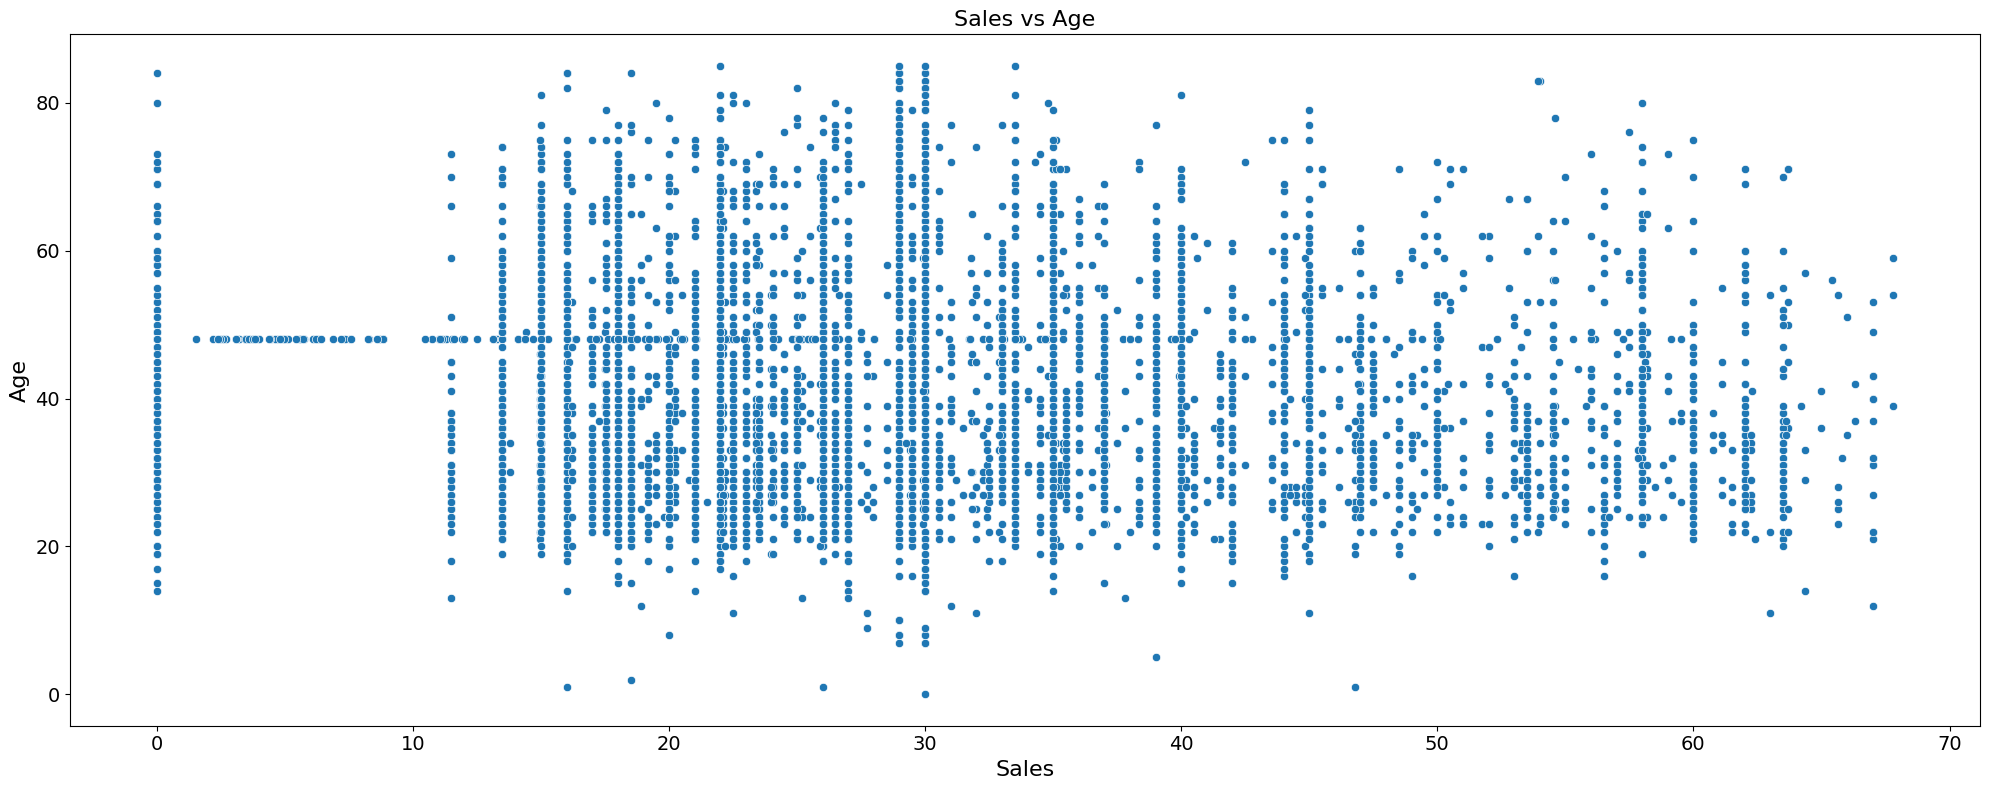

In [27]:
plot_scatter(df_analysis, 'Sales', 'Age')

In [28]:
#finaly at least
df_analysis.to_csv('df_analysis.csv', index=False)